### 04d CT & MRI Demand: Procedure Rates by Age Band (2024 Projection)

This notebook analyses the distribution of diagnostic demand for three key imaging modalities:

- **Computed Tomography (CT)**
- **Magnetic Resonance Imaging (MRI)**
- **Endoscopy** (included in summary table, excluded from visualisations)

#### Objectives:
- Calculate **absolute procedure counts** by **age band** for 2024 projected demand
- Derive **rate per 1,000 population** using ONS mid-2022 age-stratified population estimates
- Visualise patterns in CT and MRI demand using:
  - Line plots (absolute counts & rates per 1,000)
  - KDE plots (distribution of rate magnitudes)
  - Histograms (percentage of age bands by rate bin)

#### Data Inputs:
- Cleaned DIDS extract (`df`) containing valid `modality`, `age_band`, and `test_date`
- Mid-2022 population estimates used as baseline for projecting 2024 demand

#### Method Summary:
1. Aggregate counts by `modality × age_band`
2. Join with population projections
3. Compute rates per 1,000 residents
4. Visualise rate distributions for CT and MRI (excluding Endoscopy from graphs)


In [1]:
# ---------------------------------------------------
# 0 – Imports & Raw-Folder Ingestion
# ---------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib as plt
import os
import glob
import re
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# ----------- 1A. Point to your raw folder OR hard-code the list ----------
raw_dir   = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs"
csv_files = glob.glob(os.path.join(raw_dir, "*.csv"))

if not csv_files:
    raise FileNotFoundError("csv_files list is empty – check raw_dir or paths")

print(f"Detected {len(csv_files)} files")

# ----------- canonical 23-column schema from the SQL query ---------------
expected_cols = [
    'icb_code','icb_name','lsoa_code','nhs_region',
    'site_code','site_name','provider_code','provider_name',
    'activity_month','financial_year','financial_month','test_date',
    'age','sex','modality','sub_modality','procedure_name',
    'referral_type','patient_source','cancer_flag','subcancer_flag',
    'referring_org_code','referring_org_name'
]

dfs, meta = [], []
for fp in csv_files:
    peek = pd.read_csv(fp, nrows=5)
    if not set(expected_cols).issubset(peek.columns):
        print(f" {os.path.basename(fp)} – no header found, re-loading with names")
        df_tmp = pd.read_csv(fp, header=None, names=expected_cols, low_memory=False)
    else:
        df_tmp = pd.read_csv(fp, low_memory=False)

    df_tmp = df_tmp.dropna(axis=1, how='all')
    df_tmp.columns = df_tmp.columns.str.strip().str.lower()
    df_tmp = df_tmp[[c for c in expected_cols if c in df_tmp.columns]]
    for col in (set(expected_cols) - set(df_tmp.columns)):
        df_tmp[col] = pd.NA
    df_tmp = df_tmp[expected_cols]
    dfs.append(df_tmp)

    meta.append({
        "file": os.path.basename(fp),
        "rows": len(df_tmp),
        "cols": df_tmp.shape[1],
        "MB": round(df_tmp.memory_usage(deep=True).sum()/1e6, 2)
    })

meta_df = pd.DataFrame(meta)
display(meta_df.style.set_caption("Loaded files – rows / cols / size"))

df = pd.concat(dfs, ignore_index=True)
print(f"Combined shape: {df.shape}")  # expect ~4 M × 23

# Basic type coercion
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["test_date"] = pd.to_datetime(df["test_date"], errors="coerce")
df["activity_month"] = pd.to_datetime(
    df["activity_month"].astype(str), format="%Y%m", errors="coerce"
)


Detected 7 files
 2024_NHS_SW_Somerset_ICB_11X.csv – no header found, re-loading with names
 2024_NHS_SW_Cornwall_ICB_11N.csv – no header found, re-loading with names
 2024_NHS_SW_Gloucestershire_ICB_11M.csv – no header found, re-loading with names
 2024_NHS_SW_Dorset_ICB_11J.csv – no header found, re-loading with names
 2024_NHS_SW_Devon_ICB_15N.csv – no header found, re-loading with names
 2024_NHS_SW_BSW_ICB_92G.csv – no header found, re-loading with names
 2024_NHS_SW_BNSSG_ICB_15C.csv – no header found, re-loading with names


,file,rows,cols,MB
0,2024_NHS_SW_Somerset_ICB_11X.csv,481843,23,695.270000
1,2024_NHS_SW_Cornwall_ICB_11N.csv,512857,23,748.350000
2,2024_NHS_SW_Gloucestershire_ICB_11M.csv,229186,23,335.490000
3,2024_NHS_SW_Dorset_ICB_11J.csv,525091,23,762.790000
4,2024_NHS_SW_Devon_ICB_15N.csv,676563,23,991.610000
5,2024_NHS_SW_BSW_ICB_92G.csv,741719,23,1106.540000
6,2024_NHS_SW_BNSSG_ICB_15C.csv,821993,23,1240.980000


Combined shape: (3989252, 23)


In [2]:
df["patient_source"] = (
    df["patient_source"]
      .astype(str).str.strip().str.lower()
      .str.replace(r"\(this health care provider\)", "", regex=True)
      .str.replace(r"\s+-\s+", " – ", regex=True)
      .replace({"nan": np.nan})
      .fillna("unknown")
)

bucket_map = {
    r"accident|emergency|aed|a&e": "Emergency",
    r"gp direct|gp ":             "GP",
    r"inpatient":                 "Inpatient",
    r"outpatient":                "Outpatient",
    r"elective|planned":          "Elective",
}
def ps_bucket(txt: str) -> str:
    for pat, lab in bucket_map.items():
        if re.search(pat, txt):
            return lab
    return "Other/Unknown"

df["ps_bucket"] = df["patient_source"].apply(ps_bucket)
df["ps_bucket"].value_counts(dropna=False)


ps_bucket
Outpatient       1428095
GP                923522
Emergency         832850
Inpatient         695375
Other/Unknown     109410
Name: count, dtype: int64

In [3]:
# Define ONS-style bands
bands = pd.DataFrame({
    "lower":[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
    "upper":[4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,np.inf],
    "label":["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
             "40-44","45-49","50-54","55-59","60-64","65-69","70-74",
             "75-79","80-84","85+"]
})
bins   = bands["lower"].tolist() + [np.inf]
labels = bands["label"]

# Keep only whole-number ages
df = df[df["age"].notna() & (df["age"] % 1 == 0)]
df["age"] = df["age"].astype(int)
df["age_band"] = pd.cut(df["age"], bins=bins, labels=labels, right=True)


In [4]:
for col in ['modality', 'sub_modality']:
    print(f"\n Top 100 values for: {col}")

    vc = df[col].value_counts(dropna=False)
    total = vc.sum()

    top100 = vc.head(100).reset_index()
    top100.columns = [col, "Count"]
    top100["% of Total"] = (top100["Count"] / total * 100).round(2)

    display(
        top100.style
            .set_caption(f"Top 100: {col} (Count and %)")
            .format({"Count": "{:,}", "% of Total": "{:.2f}%"})
            .background_gradient(cmap="Blues", subset=["Count"])
    )

    print(f"Unique values in {col!r}: {df[col].nunique(dropna=False)}")


 Top 100 values for: modality


,modality,Count,% of Total
0,Plain radiography (procedure),"1,561,194",39.14%
1,Diagnostic ultrasonography (procedure),"782,294",19.61%
2,Computerized axial tomography (procedure),"647,463",16.23%
3,nan,"510,252",12.79%
4,Magnetic resonance imaging (procedure),"324,885",8.14%
5,Fluoroscopy (procedure),"92,541",2.32%
6,Nuclear medicine procedure (procedure),"29,358",0.74%
7,Positron emission tomography (procedure),"24,039",0.60%
8,Endoscopy (procedure),"7,174",0.18%
9,Single photon emission computerized tomography (procedure),"3,563",0.09%


Unique values in 'modality': 12

 Top 100 values for: sub_modality


,sub_modality,Count,% of Total
0,nan,"3,897,393",97.70%
1,X-ray photon absorptiometry (procedure),"42,811",1.07%
2,Diagnostic Doppler ultrasonography (procedure),"26,540",0.67%
3,Positron emission tomography with computed tomography (procedure),"20,614",0.52%
4,Single photon emission computed tomography with computed tomography (procedure),"1,830",0.05%


Unique values in 'sub_modality': 5


In [5]:
# Filter only modalities of interest
modalities_of_interest = [
    "Computerized axial tomography (procedure)",
    "Magnetic resonance imaging (procedure)",
    "Endoscopy (procedure)"
]

df_modalities = df[df["modality"].isin(modalities_of_interest)]

# Group and pivot for age_band × modality table
modality_age_table = (
    df_modalities.groupby(["modality", "age_band"])
    .size()
    .reset_index(name="count")
    .pivot(index="age_band", columns="modality", values="count")
    .fillna(0)
    .astype(int)
)

# Optional: Add row and column totals
modality_age_table["Total per Age Band"] = modality_age_table.sum(axis=1)
modality_age_table.loc["Total"] = modality_age_table.sum()

# Display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

display(modality_age_table.style.set_caption("Total Count by Age Band for Selected Modalities")
        .format("{:,}").background_gradient(cmap="Blues"))


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_4234/1678202389.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_modalities.groupby(["modality", "age_band"])


modality,Computerized axial tomography (procedure),Endoscopy (procedure),Magnetic resonance imaging (procedure),Total per Age Band
age_band,,,,
0-4,"1,488",9,"2,232","3,729"
5-9,"1,471",5,"3,554","5,030"
10-14,"2,965",14,"7,335","10,314"
15-19,"7,712",43,"9,065","16,820"
20-24,"10,019",67,"10,339","20,425"
25-29,"12,889",148,"13,701","26,738"
30-34,"17,076",167,"18,158","35,401"
35-39,"19,939",223,"20,291","40,453"
40-44,"23,414",248,"21,452","45,114"


In [17]:
# --- Step 1: Define age-band population (ONS mid-2022, used for 2024 projection) ---
age_band_population = pd.DataFrame({
    "age_band": [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
        "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
        "75-79", "80-84", "85+"
    ],
    "Population (2024 projection)": [
        283792, 322018, 331416, 324765, 342425, 342688, 367510, 355513,
        341210, 362553, 413048, 423510, 376552, 337298, 357074,
        266939, 181501, 183436
    ]
}).set_index("age_band")

# --- Step 2: Define modalities ---
modalities_of_interest = [
    "Computerized axial tomography (procedure)",
    "Magnetic resonance imaging (procedure)",
    "Endoscopy (procedure)"
]

# --- Step 3: Filter and count ---
df_modalities = df[df["modality"].isin(modalities_of_interest)]
modality_counts = (
    df_modalities
    .groupby(["age_band", "modality"], observed=True)
    .size()
    .unstack(fill_value=0)
    .astype(int)
)

# --- Step 4: Merge with population and compute rates ---
merged = age_band_population.merge(modality_counts, left_index=True, right_index=True, how="left").fillna(0)

for mod in modalities_of_interest:
    merged[f"{mod} rate / 1,000"] = (merged[mod] / merged["Population (2024 projection)"] * 1000).round(2)

merged["Total exams (absolute)"] = merged[modalities_of_interest].sum(axis=1)

# --- Step 5: Add total row safely ---
# Build a dict row by row
total_row_data = {
    "Population (2024 projection)": merged["Population (2024 projection)"].sum(),
    "Total exams (absolute)": merged["Total exams (absolute)"].sum()
}

# Add modality totals
for mod in modalities_of_interest:
    total_row_data[mod] = merged[mod].sum()

# Add rate totals (population-weighted mean rate)
for mod in modalities_of_interest:
    total_row_data[f"{mod} rate / 1,000"] = (
        merged[mod].sum() / merged["Population (2024 projection)"].sum() * 1000
    ).round(2)

# Append total row
total_row = pd.DataFrame(total_row_data, index=["Total"])
merged = pd.concat([merged, total_row])

# --- Step 6: Display ---
from IPython.display import display

display(
    merged.style
        .set_caption("CT / MRI / Endoscopy: Absolute and Per-1,000 Rates by Age Band (2024 Projection)")
        .format("{:,}", subset=["Population (2024 projection)", "Total exams (absolute)"] + modalities_of_interest)
        .format("{:.2f}", subset=[col for col in merged.columns if "rate" in col])
        .background_gradient(cmap="Blues", subset=modalities_of_interest)
)


,Population (2024 projection),Computerized axial tomography (procedure),Endoscopy (procedure),Magnetic resonance imaging (procedure),"Computerized axial tomography (procedure) rate / 1,000","Magnetic resonance imaging (procedure) rate / 1,000","Endoscopy (procedure) rate / 1,000",Total exams (absolute)
0-4,"283,792","1,488",9,"2,232",5.24,7.86,0.03,"3,729"
5-9,"322,018","1,471",5,"3,554",4.57,11.04,0.02,"5,030"
10-14,"331,416","2,965",14,"7,335",8.95,22.13,0.04,"10,314"
15-19,"324,765","7,712",43,"9,065",23.75,27.91,0.13,"16,820"
20-24,"342,425","10,019",67,"10,339",29.26,30.19,0.20,"20,425"
25-29,"342,688","12,889",148,"13,701",37.61,39.98,0.43,"26,738"
30-34,"367,510","17,076",167,"18,158",46.46,49.41,0.45,"35,401"
35-39,"355,513","19,939",223,"20,291",56.09,57.08,0.63,"40,453"
40-44,"341,210","23,414",248,"21,452",68.62,62.87,0.73,"45,114"
45-49,"362,553","26,402",292,"21,815",72.82,60.17,0.81,"48,509"


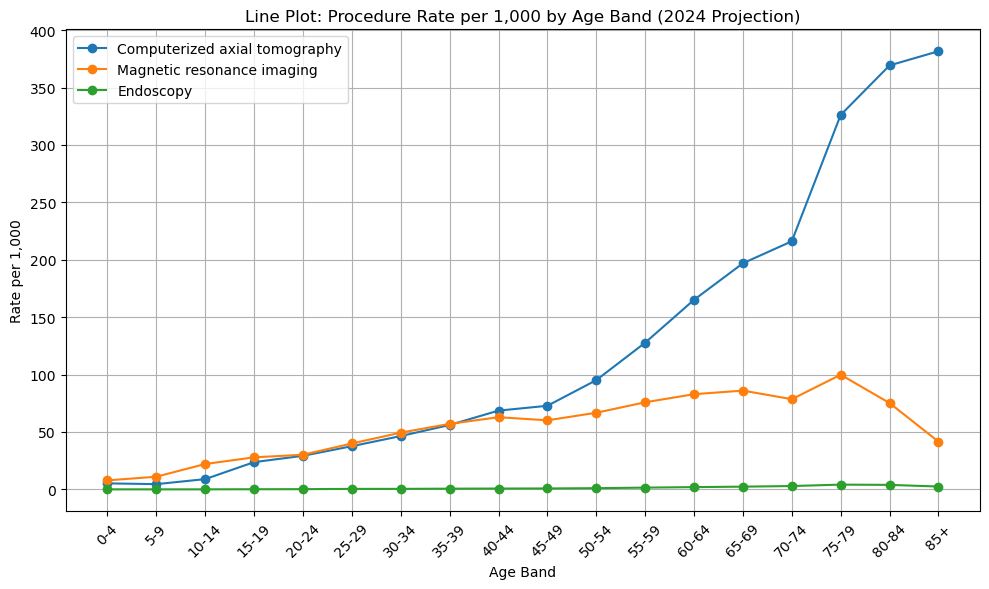

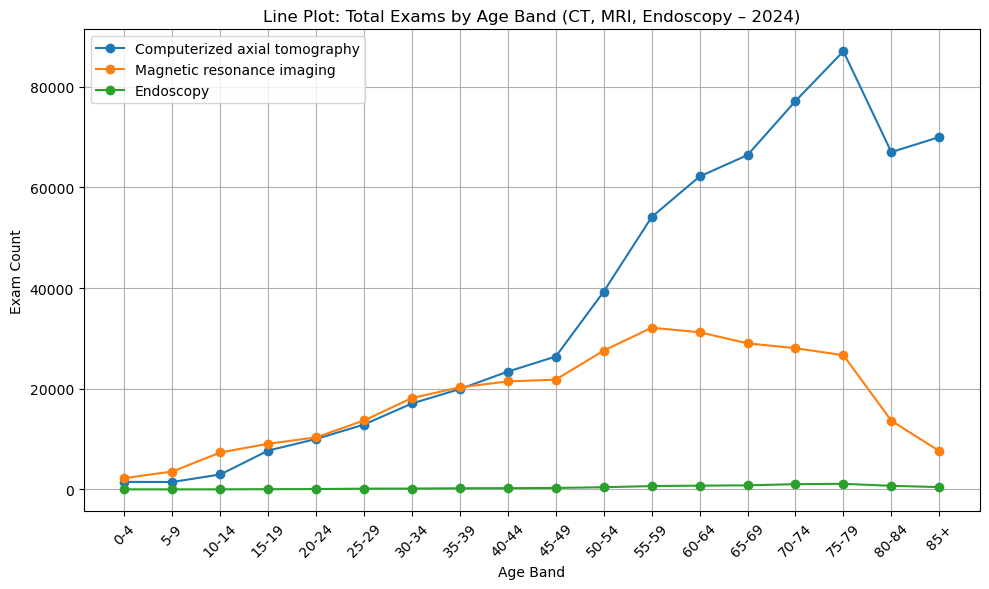

In [27]:
# Step: Rename columns so the plot loop works
plot_df = plot_df.rename(columns={
    "Computerized axial tomography (procedure)": "ct",
    "Magnetic resonance imaging (procedure)": "mri",
    "Endoscopy (procedure)": "endoscopy",
    "Computerized axial tomography (procedure) rate / 1,000": "ct rate / 1,000",
    "Magnetic resonance imaging (procedure) rate / 1,000": "mri rate / 1,000",
    "Endoscopy (procedure) rate / 1,000": "endoscopy rate / 1,000"
})

# Define plot labels
modality_labels = {
    "ct": "Computerized axial tomography",
    "mri": "Magnetic resonance imaging",
    "endoscopy": "Endoscopy"
}

# Plot 1: Rates per 1,000
plt.figure(figsize=(10, 6))
for mod, label in modality_labels.items():
    plt.plot(plot_df["age_band"], plot_df[f"{mod} rate / 1,000"], marker='o', label=label)

plt.title("Line Plot: Procedure Rate per 1,000 by Age Band (2024 Projection)")
plt.xlabel("Age Band")
plt.ylabel("Rate per 1,000")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Raw counts
plt.figure(figsize=(10, 6))
for mod, label in modality_labels.items():
    plt.plot(plot_df["age_band"], plot_df[mod], marker='o', label=label)

plt.title("Line Plot: Total Exams by Age Band (CT, MRI, Endoscopy – 2024)")
plt.xlabel("Age Band")
plt.ylabel("Exam Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# Define export path
export_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed/modality_rates_by_ageband_2024.csv"

# Export to CSV
merged.to_csv(export_path)

print("Data exported to:")
print(export_path)


Data exported to:
/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed/modality_rates_by_ageband_2024.csv
